### Elevation trend analysis based on altimeter data.
#### 1) Elevation change rate correction with the linear fitting of elevation changes on the stable region. 
#### $(\frac{dh}{dt})_{glacier-cor} = (\frac{dh}{dt})_{glacier} - (\frac{dh}{dt})_{stable}$
#### 2) Uncertainty estimation of elevation change rate. 
#### $\epsilon_{ransac} = y_i - y_{fitting}$
#### $\sigma_{dh} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\epsilon_{i} - \overline{\epsilon})^2} $
#### $\sigma_\frac{dh}{dt} = \frac{\sigma_{dh}}{dt}$
The n refer to the number of the years, and the i is the i-th year.
### Content:
##### 1. Icesat-1
<font color=pink> **!!!! Note: the Icesat-1 data are very sparse and the calculation for tiles is not conduct.** </font> 
- 1.1 Area weighted elevation differece and uncertainty estimation.
- 1.2 Write out the result.
##### 2. Icesat-2.
- 2.1 Result for overall setp region.
- 2.2 Result by tiles.
- 2.3 Result by bins
- 2.4 Write out the result.
##### 3. Cryosat-2.
<font color=pink> **!!!! Note: the cryosat-2 eolis point data only contain the data on the glacier region. therefore, the elevation correction for yearly elevation changes is not conduct for the eolis data.  
However, to align the elevation change with that derived by another data, the global bias of elevation change is removed by using the mean elevation change difference with the icesat-2 derived result.

refering to the elevation change derived by icesat-2.** 
</font> 

- 3.1 Result for overall setp region.   
- 3.2 Result by tiles.   
- 3.3 Result by bins.     
- 3.4 Write out the result.     



In [1]:
import os 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from utils.tiles_bins_weighting import stat_bins_weighting, stat_tiles_weighting
from utils.tiles_bins_weighting import stat_bins_tiles_weighting, stat_tiles_bins_weighting
from utils.ransac_fitting import ransac_fitting


In [2]:
### Read in
path_sta_isat1 = 'data/icesat-1/stat_dif_isat1.nc'
path_sta_isat2 = 'data/icesat-2/stat_dif_isat2.nc'
path_sta_cryo2 = 'data/cryosat-2/stat_dif_cryo2.nc'
### Write out
path_result_isat1 = 'data/icesat-1/result_isat1.nc'
path_result_isat2 = 'data/icesat-2/result_isat2.nc'
path_result_cryo2 = 'data/cryosat-2/result_cryo2.nc'


In [3]:
stat_isat1_xr = xr.open_dataset(path_sta_isat1)
stat_isat2_xr = xr.open_dataset(path_sta_isat2)
stat_cryo2_xr = xr.open_dataset(path_sta_cryo2)
years_isat1, years_isat2, years_cryo2 = stat_isat1_xr.years.values, stat_isat2_xr.years.values, stat_cryo2_xr.years.values
bins_id_isat2, bins_id_cryo2 = stat_isat2_xr.bins_id.values, stat_cryo2_xr.bins_id.values
tiles_id = stat_isat2_xr.tiles_id.values
years_cryo2



array(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021', '2022'], dtype=object)

### 1. ICESAT-1 
#### 1.1 Area weighted elevation differece and robust linear fitting by ransac algorithm.


In [4]:
# stat_isat1_xr['mean_stable_tiles_years'].values


In [5]:
# stat_isat1_xr['mean_glacier_tiles_years'].values

In [6]:
# mean_binsWeighted_isat1, std_binsWeighted_isat1 = stat_bins_weighting(mean_bins=stat_isat1_xr['mean_glacier_bins'], \
#                                     std_bins=stat_isat1_xr['std_glacier_bins'], glacier_area_bins=stat_isat1_xr['area_glacier_bins'])
mean_setp_glacier_isat1, std_setp_glacier_isat1 = stat_tiles_weighting(mean_tiles=stat_isat1_xr['mean_glacier_tiles_years'], \
                                            std_tiles=stat_isat1_xr['std_glacier_tiles_years'], glacier_area_tiles=stat_isat1_xr['area_glacier_tiles'])
mean_setp_stable_isat1, std_setp_stable_isat1 = stat_tiles_weighting(mean_tiles=stat_isat1_xr['mean_stable_tiles_years'], \
                                            std_tiles=stat_isat1_xr['std_stable_tiles_years'], glacier_area_tiles=stat_isat1_xr['area_glacier_tiles'])
mean_setp_glacier_cor_isat1 = mean_setp_glacier_isat1 - mean_setp_stable_isat1   ### elevation change correction.
mean_setp_glacier_filtered_isat1, mean_setp_glacier_fitting_isat1, rate_setp_glacier_isat1 = ransac_fitting(x=np.arange(len(years_isat1)), y=mean_setp_glacier_cor_isat1, thre_mask=50)
### standard deviation of elevation change.
std_setp_glacier_cor_isat1 = np.sqrt(np.square(std_setp_glacier_isat1) + np.square(std_setp_stable_isat1)) 
print('Elevation change rate by icesat1:',rate_setp_glacier_isat1[0])




Elevation change rate by icesat1: -2.1087093641316152


#### 1.2 Uncertainty estimation

In [7]:
#### 1. Time interval: 2000-2021
epsilon = mean_setp_glacier_cor_isat1.values - mean_setp_glacier_fitting_isat1
sigma_dh = np.std(epsilon)
sigma_dh_dt_isat1 = sigma_dh/len(years_isat1)
print('sigma_dh:', sigma_dh)
print('sigma_dh_dt of Icesat-1:', sigma_dh_dt_isat1)


sigma_dh: 3.59285416711437
sigma_dh_dt of Icesat-1: 0.5132648810163386


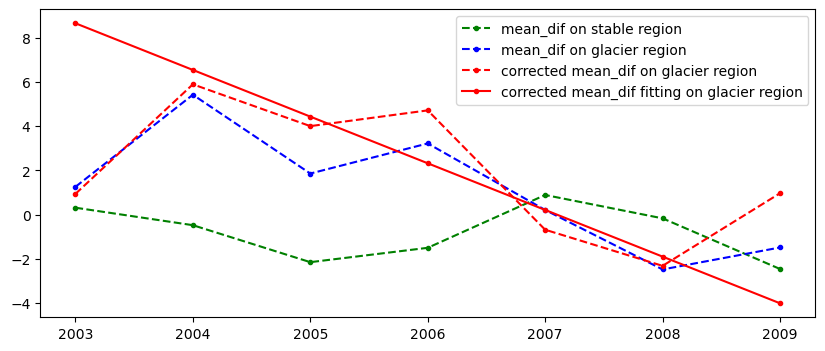

In [8]:
plt.figure(figsize=(10,4))
plt.plot(years_isat1, mean_setp_stable_isat1, '.--g', label='mean_dif on stable region')
plt.plot(years_isat1, mean_setp_glacier_isat1, '.--b', label='mean_dif on glacier region')
plt.plot(years_isat1, mean_setp_glacier_cor_isat1, '.--r', label='corrected mean_dif on glacier region')
plt.plot(years_isat1, mean_setp_glacier_fitting_isat1, '.-r', label='corrected mean_dif fitting on glacier region')
plt.legend()

#### 1.3 Result by tiles.

In [9]:
rate_tiles_isat1, rate_tiles_error_isat1, mean_tiles_glacier_isat1_cor = [], [], []
for tile_id in tiles_id:
  # tile_id =  'tile_27_98'
  # print(tile_id)
  mean_tile_glacier = stat_isat1_xr['mean_glacier_tiles_years'].sel(tiles_id=tile_id).values
  mean_tile_stable = stat_isat1_xr['mean_stable_tiles_years'].sel(tiles_id = tile_id).values
  mean_tile_glacier_cor = mean_tile_glacier - mean_tile_stable        ### Elevation change correction
  mean_tiles_glacier_isat1_cor.append(mean_tile_glacier_cor)
  ids_valid = np.where(~np.isnan(mean_tile_glacier_cor))[0]
  if ids_valid.shape[0]>2:
    mean_tile_glacier_cor_filtered, mean_tile_glacier_cor_fitting, rate_tile_glacier_cor = \
                                          ransac_fitting(x=np.arange(len(years_isat1)), y=mean_tile_glacier_cor, thre_mask=50)
    rate_tiles_isat1.append(rate_tile_glacier_cor[0])
    ## Uncertainty.
    epsilon = mean_tile_glacier_cor - mean_tile_glacier_cor_fitting
    sigma_dh = np.nanstd(epsilon)
    sigma_dh_dt = sigma_dh/len(years_isat1)
    rate_tiles_error_isat1.append(sigma_dh_dt)
  else: 
    rate_tiles_isat1.append(np.nan)
    rate_tiles_error_isat1.append(np.nan)
  # break

mean_tiles_glacier_isat1_cor = np.stack(mean_tiles_glacier_isat1_cor, axis=0) 
mean_tiles_glacier_isat1_cor.shape



(28, 7)

#### 1.3 Write out the result.

In [10]:
result_isat1_xr =xr.Dataset(
        {
        'ele_change_setp_cor': (["years"], mean_setp_glacier_cor_isat1.values),
        'ele_change_setp_cor_std': (["years"], std_setp_glacier_cor_isat1.values),
        'ele_change_setp_cor_fitting': (["years"], mean_setp_glacier_fitting_isat1),
        'rate_setp': rate_setp_glacier_isat1[0],
        'rate_setp_error': sigma_dh_dt_isat1,
        },
        coords={
                'years': years_isat1,
                })
if os.path.exists(path_result_isat1): os.remove(path_result_isat1)
result_isat1_xr.to_netcdf(path_result_isat1)


### 2. ICESAT-2

#### 2.1 For the overall setp region.

In [11]:
mean_setp_stable_isat2, std_setp_stable_isat2 = stat_tiles_weighting(mean_tiles = stat_isat2_xr['mean_stable_tiles'], \
                                                                    std_tiles = stat_isat2_xr['std_stable_tiles'], 
                                                                    glacier_area_tiles = stat_isat2_xr['area_glacier_tiles'])
### From bins weighting to tiles weighting.
mean_tiles_glacier_isat2, std_tiles_glacier_isat2, mean_setp_glacier_isat2, std_setp_glacier_isat2 = \
                                                stat_bins_tiles_weighting(mean_tiles_bins=stat_isat2_xr['mean_glacier_tiles_bins'], \
                                                                    std_tiles_bins=stat_isat2_xr['std_glacier_tiles_bins'], 
                                                                    glacier_area_tiles_bins=stat_isat2_xr['area_glacier_tiles_bins'])
#### elevation change correction
mean_setp_glacier_cor_isat2 = mean_setp_glacier_isat2.values - mean_setp_stable_isat2.values
### standard deviation of the corercted elevation change.
std_setp_glacier_cor_isat2 = np.sqrt(np.square(std_setp_stable_isat2.values) + np.square(std_setp_glacier_isat2.values)) 



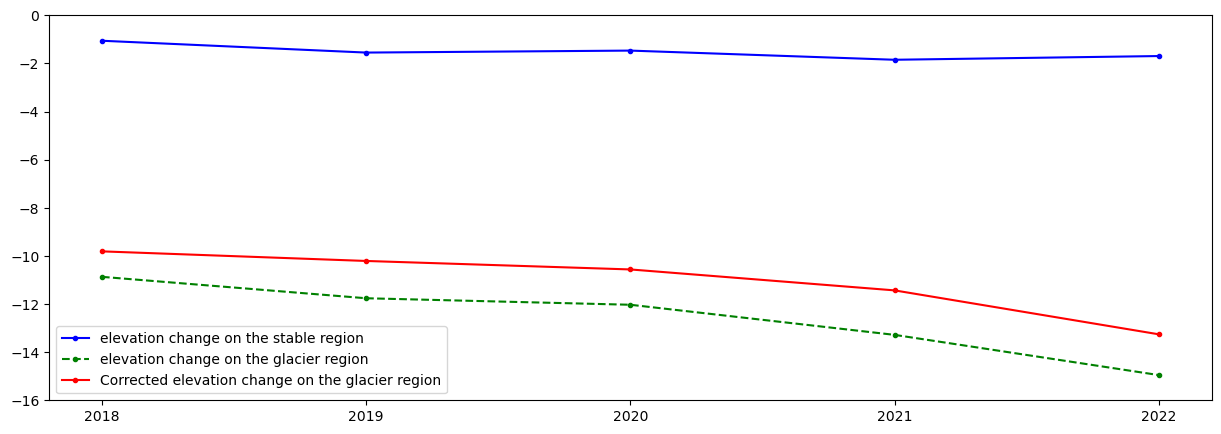

In [12]:
plt.figure(figsize=(15,5))
plt.plot(years_isat2, mean_setp_stable_isat2, '.-b', label='elevation change on the stable region')
plt.plot(years_isat2, mean_setp_glacier_isat2, '.--g', label='elevation change on the glacier region')   ### 
plt.plot(years_isat2, mean_setp_glacier_cor_isat2, '.-r', label='Corrected elevation change on the glacier region')   ### 
plt.ylim(top=0, bottom=-16)
plt.legend()



##### Robust linear fitting by ransac algorithm.

In [13]:
mean_setp_glacier_cor_filtered_isat2, mean_setp_glacier_cor_fitting_isat2, rate_setp_glacier_cor_isat2 \
                                        = ransac_fitting(x=np.arange(len(years_isat2)), y=mean_setp_glacier_cor_isat2, thre_mask=50)
print('Elevation change rate by Icesat-2:', rate_setp_glacier_cor_isat2[0])


Elevation change rate by Icesat-2: -0.5216873637877977


#### Uncertainty estimation


In [14]:
epsilon = mean_setp_glacier_cor_isat2 - mean_setp_glacier_cor_fitting_isat2
sigma_dh = np.std(epsilon)
sigma_dh_dt_isat2 = sigma_dh/len(years_isat2)
# print('sigma_dh:', sigma_dh)
print('sigma_dh_dt of Icesat-2:', sigma_dh_dt_isat2)


sigma_dh_dt of Icesat-2: 0.11843029858462643


#### 2.2 Result by tiles.

In [15]:
rate_tiles_isat2, rate_tiles_error_isat2, mean_tile_glacier_isat2_cor = [], [], []
for tile_id in tiles_id:
  # tile_id =  'tile_27_98'
  mean_tile_glacier = mean_tiles_glacier_isat2.sel(tiles_id=tile_id).values
  mean_tile_stable = stat_isat2_xr['mean_stable_tiles'].sel(tiles_id = tile_id).values
  mean_tile_glacier_cor = mean_tile_glacier - mean_tile_stable    ### elevation change correction
  mean_tile_glacier_isat2_cor.append(mean_tile_glacier_cor)
  ids_valid = np.where(~np.isnan(mean_tile_glacier_cor))[0]
  if ids_valid.shape[0]>2:
    mean_tile_glacier_cor_filtered, mean_tile_glacier_cor_fitting, rate_tile_glacier_cor = \
                                          ransac_fitting(x=np.arange(len(years_isat2)), y=mean_tile_glacier_cor, thre_mask=50)
    rate_tiles_isat2.append(rate_tile_glacier_cor[0])
    ## Uncertainty.
    epsilon = mean_tile_glacier_cor - mean_tile_glacier_cor_fitting
    sigma_dh = np.nanstd(epsilon)
    sigma_dh_dt = sigma_dh/len(years_isat2)
    rate_tiles_error_isat2.append(sigma_dh_dt)
  else: 
    rate_tiles_isat2.append(np.nan)
    rate_tiles_error_isat2.append(np.nan)

mean_tile_glacier_isat2_cor = np.stack(mean_tile_glacier_isat2_cor, axis=0) 
mean_tile_glacier_isat2_cor.shape
  # break


(28, 5)

##### 2.3 Result by bins ( ! no correction)

In [16]:
### From bins weighting to tiles weighting.
mean_bins_glacier_isat2, std_bins_glacier_isat2, mean_setp_glacier_isat2, std_setp_glacier_isat2 = \
                                                stat_tiles_bins_weighting(mean_tiles_bins=stat_isat2_xr['mean_glacier_tiles_bins'], \
                                                                    std_tiles_bins=stat_isat2_xr['std_glacier_tiles_bins'], 
                                                                    glacier_area_tiles_bins=stat_isat2_xr['area_glacier_tiles_bins'])
rate_bins_isat2, rate_bins_error_isat2, ele_change_bins = [], [], []

for bin_id in bins_id_isat2:
    ele_change_bin = mean_bins_glacier_isat2.sel(bins_id = bin_id).values
    ele_change_bin = np.where(ele_change_bin == 0, np.nan, ele_change_bin)
    ids_valid = np.where(~np.isnan(ele_change_bin))[0]
    if ids_valid.shape[0]>2:
        mean_bin_glacier_filtered, mean_bin_glacier_fitting, rate_bin_glacier = ransac_fitting(x=np.arange(len(years_isat2)), y=ele_change_bin, thre_mask=50)
        rate_bins_isat2.append(rate_bin_glacier[0])
        ele_change_bins.append(ele_change_bin)
        ## Uncertainty.
        epsilon =  ele_change_bin - mean_bin_glacier_fitting
        sigma_dh = np.nanstd(epsilon)
        sigma_dh_dt = sigma_dh/len(years_isat2)
        rate_bins_error_isat2.append(sigma_dh_dt)
    else:
        rate_bins_isat2.append(np.nan)
        ele_change_bins.append(np.nan)
        rate_bins_error_isat2.append(np.nan)
area_glacier_bins = stat_isat2_xr['area_glacier_tiles_bins'].sum(dim='tiles_id').values


#### 2.4 Write out the result.

In [17]:
### 3) write out statistic of stable region to the xarray .nc file.
tiles_lat, tiles_lon = [], []
for tile_id in tiles_id:
    tiles_lat.append(int(tile_id[5:7]))
    tiles_lon.append(int(tile_id[8:]))

### Conver to xarray data.
result_isat2_xr =xr.Dataset(
        {
        'tiles_lat': (["tiles_id"], tiles_lat),
        'tiles_lon': (["tiles_id"], tiles_lon),
        "area_glacier_tiles": (["tiles_id"], stat_isat2_xr['area_glacier_tiles'].values),
        "area_glacier_bins": (["bins_id"], area_glacier_bins),
        "ele_change_setp_cor": (["years"], mean_setp_glacier_cor_isat2),
        "ele_change_setp_cor_fitting": (["years"], mean_setp_glacier_cor_fitting_isat2),
        "ele_change_setp_cor_std": (["years"], std_setp_glacier_cor_isat2),
        'rate_setp': rate_setp_glacier_cor_isat2[0],
        'rate_setp_error': sigma_dh_dt_isat2, 
        'rate_tiles': (["tiles_id"], rate_tiles_isat2),
        'rate_tiles_error': (["tiles_id"], rate_tiles_error_isat2),
        'rate_bins': (["bins_id"], rate_bins_isat2),
        'rate_bins_error': (["bins_id"], rate_bins_error_isat2), 
        },
        coords={'tiles_id': tiles_id,
                'bins_id': bins_id_isat2,
                'years': years_isat2})

if os.path.exists(path_result_isat2): os.remove(path_result_isat2)
result_isat2_xr.to_netcdf(path_result_isat2)


### 3. Cryosat-2

#### 3.1 For the overall setp region. (! no stable region-based correction, but overall elevation change bias correction is performed by icesat-2 derived result.)

In [18]:
### Bins and tiles-based glacier area weighted elevation change.
mean_tiles_glacier_cryo2, std_tiles_glacier_cryo2, mean_setp_glacier_cryo2, std_setp_glacier_cryo2 = \
                                                stat_bins_tiles_weighting(mean_tiles_bins=stat_cryo2_xr['mean_glacier_tiles_bins'], \
                                                                    std_tiles_bins=stat_cryo2_xr['std_glacier_tiles_bins'], 
                                                                    glacier_area_tiles_bins=stat_cryo2_xr['area_glacier_tiles_bins'])
ids_isat2_of_cryo2 = [np.where(year == years_cryo2)[0].item() for year in years_isat2]
bias_cryo2_isat2 = (mean_setp_glacier_cor_isat2-mean_setp_glacier_cryo2[ids_isat2_of_cryo2]).mean().values
mean_tiles_glacier_cor_cryo2, mean_setp_glacier_cor_cryo2 = mean_tiles_glacier_cryo2+bias_cryo2_isat2, mean_setp_glacier_cryo2+bias_cryo2_isat2
bias_cryo2_isat2


array(6.87361685)

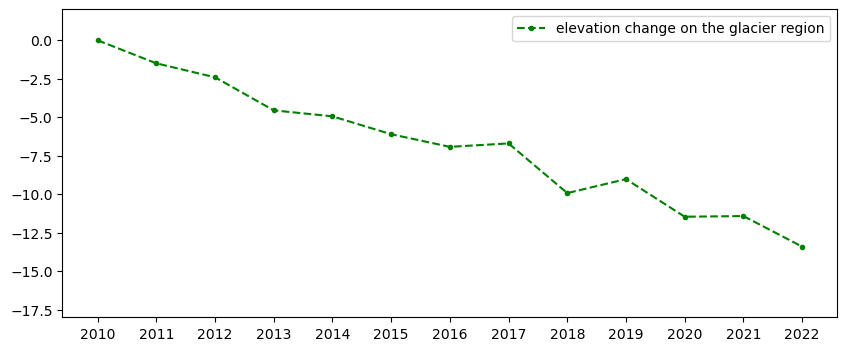

In [19]:
plt.figure(figsize=(10,4))
plt.plot(years_cryo2, mean_setp_glacier_cor_cryo2, '.--g', label='elevation change on the glacier region')   ### 
plt.ylim(top=2, bottom=-18)
plt.legend()


##### Robust linear fitting by ransac algorithm.

In [20]:
mean_setp_glacier_cor_filtered_cryo2, mean_setp_glacier_cor_fitting_cryo2, rate_setp_glacier_cor_cryo2 \
                                = ransac_fitting(x=np.arange(len(years_cryo2)), y=mean_setp_glacier_cor_cryo2, thre_mask=50)
print('Elevation change rate by cryo-2:', rate_setp_glacier_cor_cryo2[0])


Elevation change rate by cryo-2: -1.0448974565652625


#### Uncertainty estimation

In [21]:
epsilon = mean_setp_glacier_cor_cryo2.values - mean_setp_glacier_cor_fitting_cryo2
sigma_dh = np.std(epsilon)
sigma_dh_dt_cryo2 = sigma_dh/len(years_cryo2)
# print('sigma_dh:', sigma_dh)
print('sigma_dh_dt of Cryo-2:', sigma_dh_dt_cryo2)


sigma_dh_dt of Cryo-2: 0.048820663612327654


#### 3.2 Result by tiles. (! no stable region correction but overall elevation change bias correction is performed.)


In [22]:
rate_tiles_cor_cryo2, rate_tiles_error_cor_cryo2 = [], []
for tile_id in tiles_id:
  # tile_id =  'tile_27_98'
  mean_tile_glacier_cor = mean_tiles_glacier_cor_cryo2.sel(tiles_id=tile_id).values
  ids_valid = np.where(~np.isnan(mean_tile_glacier_cor))[0]
  if ids_valid.shape[0]>2:
    mean_tile_glacier_cor_filtered, mean_tile_glacier_cor_fitting, rate_tile_glacier_cor = \
                                            ransac_fitting(x=np.arange(len(years_cryo2)), y=mean_tile_glacier_cor, thre_mask=50)
    rate_tiles_cor_cryo2.append(rate_tile_glacier_cor[0])
    ## Uncertainty.
    epsilon = mean_tile_glacier_cor - mean_tile_glacier_cor_fitting
    sigma_dh = np.nanstd(epsilon)
    sigma_dh_dt = sigma_dh/len(years_cryo2)
    rate_tiles_error_cor_cryo2.append(sigma_dh_dt)
  else: 
    rate_tiles_cor_cryo2.append(np.nan)
    rate_tiles_error_cor_cryo2.append(np.nan)

rate_tiles_cor_cryo2
rate_tiles_error_cor_cryo2


[nan,
 nan,
 nan,
 nan,
 nan,
 0.5338675466953163,
 0.2612260038718567,
 0.394205506403118,
 nan,
 0.36568816034083085,
 0.34589421774570867,
 0.2930214240933253,
 0.20705471508117,
 0.13510756182460867,
 0.16806457825426485,
 0.5901943566741743,
 1.1130251600312784,
 0.5738119674598414,
 0.17606900365161865,
 0.27594344413524635,
 0.1535862677562743,
 1.596873830986047,
 nan,
 nan,
 nan,
 0.1521399667289745,
 0.12447109508583612,
 nan]

##### 3.3 Result by bins (! no correction)

In [24]:
### From bins weighting to tiles weighting.
mean_bins_glacier_cor_cryo2, std_bins_glacier_cor_cryo2, mean_setp_glacier_cor_cryo2, std_setp_glacier_cor_cryo2 = \
                                                stat_tiles_bins_weighting(mean_tiles_bins=stat_cryo2_xr['mean_glacier_tiles_bins'], \
                                                                    std_tiles_bins=stat_cryo2_xr['std_glacier_tiles_bins'], 
                                                                    glacier_area_tiles_bins=stat_cryo2_xr['area_glacier_tiles_bins'])
### Elevation change bias correction for bins.
mean_bins_glacier_cor_cryo2, mean_setp_glacier_cor_cryo2 = mean_bins_glacier_cor_cryo2+bias_cryo2_isat2, mean_setp_glacier_cor_cryo2+bias_cryo2_isat2
rate_bins_cor_cryo2, rate_bins_error_cor_cryo2, ele_change_bins_cor = [], [], []

for bin_id in bins_id_cryo2:
    ele_change_bin_cor = mean_bins_glacier_cor_cryo2.sel(bins_id = bin_id).values
    ele_change_bin_cor = np.where(ele_change_bin_cor == 0, np.nan, ele_change_bin_cor)
    ids_valid = np.where(~np.isnan(ele_change_bin_cor))[0]
    if ids_valid.shape[0]>2:
        mean_bin_glacier_cor_filtered, mean_bin_glacier_cor_fitting, rate_bin_glacier_cor = ransac_fitting(x=np.arange(len(years_cryo2)), y=ele_change_bin_cor, thre_mask=50)
        rate_bins_cor_cryo2.append(rate_bin_glacier_cor[0])
        ele_change_bins_cor.append(ele_change_bin_cor)
        ## Uncertainty.
        epsilon =  ele_change_bin_cor - mean_bin_glacier_cor_fitting
        sigma_dh = np.nanstd(epsilon)
        sigma_dh_dt = sigma_dh/len(years_cryo2)
        rate_bins_error_cor_cryo2.append(sigma_dh_dt)
    else:
        rate_bins_cor_cryo2.append(np.nan)
        ele_change_bin_cor.append(np.nan)
        rate_bins_error_cor_cryo2.append(np.nan)
area_glacier_bins = stat_cryo2_xr['area_glacier_tiles_bins'].sum(dim='tiles_id').values



##### 3.4 Write out the result.

In [25]:
tiles_lat, tiles_lon = [], []
for tile_id in tiles_id:
    tiles_lat.append(int(tile_id[5:7]))
    tiles_lon.append(int(tile_id[8:]))

### Conver to xarray data.
result_cryo2_xr =xr.Dataset(
        {
        'tiles_lat': (["tiles_id"], tiles_lat),
        'tiles_lon': (["tiles_id"], tiles_lon),
        "area_glacier_tiles": (["tiles_id"], stat_cryo2_xr['area_glacier_tiles'].values),
        "area_glacier_bins": (["bins_id"], area_glacier_bins),
        "ele_change_setp_cor": (["years"], mean_setp_glacier_cor_cryo2.values),
        "ele_change_setp_cor_std": (["years"], std_setp_glacier_cor_cryo2.values),
        "ele_change_setp_cor_fitting": (["years"], mean_setp_glacier_cor_fitting_cryo2),
        'rate_setp': rate_setp_glacier_cor_cryo2[0],
        'rate_setp_error': sigma_dh_dt_cryo2, 
        'rate_tiles': (["tiles_id"], rate_tiles_cor_cryo2),
        'rate_tiles_error': (["tiles_id"], rate_tiles_error_cor_cryo2),
        'rate_bins': (["bins_id"], rate_bins_cor_cryo2),
        'rate_bins_error': (["bins_id"], rate_bins_error_cor_cryo2), 
        },
        coords={'tiles_id': tiles_id,
                'bins_id': bins_id_cryo2,
                'years': years_cryo2})

if os.path.exists(path_result_cryo2): os.remove(path_result_cryo2)
result_cryo2_xr.to_netcdf(path_result_cryo2)
